<a href="https://colab.research.google.com/github/kairamilanifitria/NLP-Projects/blob/main/Project%203%20Voice%20Recognition/P3_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Splitting

In [1]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets[audio]
!pip install evaluate
!pip install jiwer
!pip install datasets --upgrade
!pip install rouge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import IPython.display as ipd
import torch
import transformers
import datasets
import librosa
import re
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
import nltk
import librosa.display
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from IPython.display import display as ipd
from IPython.display import HTML
from datasets import load_dataset, ClassLabel, Audio # Remove load_metric from here
from evaluate import load # Import load from evaluate instead
from transformers import WhisperConfig, WhisperProcessor, WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, DataCollator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, Trainer, TrainingArguments
from transformers import pipeline
from transformers.utils import send_example_telemetry

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import AdamW
from datasets import DatasetDict
from datasets import concatenate_datasets

from rouge import Rouge

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False  --include 'en-US/*'

minds_enUS = load_dataset('./en-US', split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 1 files:   0% 0/1 [00:00<?, ?it/s]Downloading 'en-US/train/0000.parquet' to '.cache/huggingface/download/en-US/train/0000.parquet.07f4309eeb2eaec72b31960d6408544b17a4a08d8c49ad41f2b6f2c79962108b.incomplete'

0000.parquet:   0% 0.00/34.2M [00:00<?, ?B/s]
0000.parquet: 100% 34.2M/34.2M [00:00<00:00, 150MB/s]
Download complete. Moving file to en-US/train/0000.parquet
Fetching 1 files: 100% 1/1 [00:00<00:00,  1.69it/s]
/content


Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
print(minds_enUS)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})


In [5]:
merged_dataset = concatenate_datasets([minds_enUS])

print(merged_dataset)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})


In [6]:
intent_classes = [
    {'index': 0, 'name': 'abroad'},
    {'index': 1, 'name': 'adress'},
    {'index': 2, 'name': 'app_error'},
    {'index': 3, 'name': 'atm_limit'},
    {'index': 4, 'name': 'balance'},
    {'index': 5, 'name': 'business_loan'},
    {'index': 6, 'name': 'card_issues'},
    {'index': 7, 'name': 'cash_deposite'},
    {'index': 8, 'name': 'direct_debit'},
    {'index': 9, 'name': 'freeze'},
    {'index': 10, 'name': 'latest_transactions'},
    {'index': 11, 'name': 'joint_account'},
    {'index': 12, 'name': 'high_value_payment'},
    {'index': 13, 'name': 'pay_bill'}
]

In [7]:
def count_feature_lengths(dataset):
    feature_lengths = {}

    for feature in dataset.features:
        values = dataset[feature]
        lengths = [len(str(value)) if not isinstance(value, (int, float, dict, list)) else 1 for value in values]
        feature_lengths[feature] = lengths
    return feature_lengths

feature_lengths = count_feature_lengths(merged_dataset)

for feature, lengths in feature_lengths.items():
    print(f"{feature}: {len(lengths)}")

path: 563
audio: 563
transcription: 563
english_transcription: 563
intent_class: 563
lang_id: 563


In [8]:
feature_lengths = count_feature_lengths(minds_enUS)

for feature, lengths in feature_lengths.items():
    print(f"{feature}: {len(lengths)}")

path: 563
audio: 563
transcription: 563
english_transcription: 563
intent_class: 563
lang_id: 563


In [9]:
def remove_columns(example):
  del example["english_transcription"]
  del example["lang_id"]
  del example["path"]
  del example["audio"]
  return example

dataset = merged_dataset.map(remove_columns)

dataset

Map:   0%|          | 0/563 [00:00<?, ? examples/s]

Dataset({
    features: ['transcription', 'intent_class'],
    num_rows: 563
})

In [10]:
dataset[1]

{'transcription': 'Henry County set up a joint account with my wife and where are they at',
 'intent_class': 11}

In [11]:
df = pd.DataFrame(dataset)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [12]:
test_df

,transcription,intent_class
250,hi what's the maximum amount of money I can wi...,3
521,my card isn't working in the office on speaker...,6
268,I'm thinking about withdrawing money from I wa...,3
55,what's my current balance,4
549,hi I'm calling to ask about the rates on new b...,5
...,...,...
88,teach me how to pay bill online,13
320,I'm having trouble understanding what a direct...,8
357,hey can I see a history of my most recent tran...,12
33,hello yes my son is going off to college and I...,11


In [30]:
test_df.to_csv('test.csv', index=False)
from google.colab import files
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
train_df

,transcription,intent_class
324,hi there I wanted to inquire about Black Sabba...,8
477,how can I deposit cash to my account,7
0,I would like to set up a joint account with my...,11
11,how do I go about setting up a joint account f...,11
290,hi I'm going to be leaving the country and I'm...,0
...,...,...
71,I would like to know the amount in my current ...,4
106,pay my credit card bill,13
270,what is the maximum amount of cash that I can ...,3
435,hey I want to deposit some money into my accou...,7


In [31]:
train_df.to_csv('train.csv', index=False)
from google.colab import files
files.download('train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load Dataset

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import pandas as pd
import torch

In [21]:
def load_data(train_path, test_path):
    train_df = pd.read_csv("/content/train.csv")
    test_df = pd.read_csv("/content/test.csv")

    # Convert 'intent_class' to integer labels
    train_df['label'] = train_df['intent_class'].apply(lambda x: int(x))
    test_df['label'] = test_df['intent_class'].apply(lambda x: int(x))

    # Create Dataset objects
    train_dataset = Dataset.from_pandas(train_df[['transcription', 'label']])
    test_dataset = Dataset.from_pandas(test_df[['transcription', 'label']])
    return train_dataset, test_dataset

In [22]:
# Set your dataset paths
train_path = "/content/train.csv"
test_path = "/content/test.csv"
train_dataset, test_dataset = load_data(train_path, test_path)

In [23]:
# Load RoBERTa tokenizer and model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=14)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["transcription"], padding="max_length", truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

In [25]:
# Define the evaluation metric
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [26]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,             # Ensures no conflicts with previous runs
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,                    # Adjust epochs as needed
    learning_rate=1e-5,                    # Recommended starting LR for roberta-base
    weight_decay=0.01,
    warmup_steps=500,
    max_grad_norm=1.0,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

In [10]:
import wandb
wandb.init(mode="disabled")

In [28]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=280, training_loss=2.0678922653198244, metrics={'train_runtime': 791.3584, 'train_samples_per_second': 11.373, 'train_steps_per_second': 0.354, 'total_flos': 2287733976428544.0, 'train_loss': 2.0678922653198244, 'epoch': 19.310344827586206})

In [29]:
# Evaluate the model
eval_result = trainer.evaluate()

In [30]:
# Print evaluation results
print("Evaluation Results:", eval_result)

Evaluation Results: {'eval_loss': 0.509617805480957, 'eval_accuracy': 0.9469026548672567, 'eval_precision': 0.9534995977473854, 'eval_recall': 0.9469026548672567, 'eval_f1': 0.9463111622540648, 'eval_runtime': 3.4795, 'eval_samples_per_second': 32.476, 'eval_steps_per_second': 2.299, 'epoch': 19.310344827586206}


In [31]:
# Detailed evaluation
def detailed_evaluation(trainer, test_dataset):
    # Predict on the test set
    preds_output = trainer.predict(test_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels = preds_output.label_ids

    # Confusion matrix
    conf_matrix = confusion_matrix(labels, preds)
    print("Confusion Matrix:\n", conf_matrix)

    # Classification report
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Run detailed evaluation
detailed_evaluation(trainer, tokenized_test)

Confusion Matrix:
 [[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  0  8  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10]]
Accuracy: 0.9469
Precision: 0.9535
Recall: 0.9469
F1 Score: 0.9463


Confusion Matrix:
 [[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  0  8  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10]]
Accuracy: 0.9469
Precision: 0.9535
Recall: 0.9469
F1 Score: 0.9463


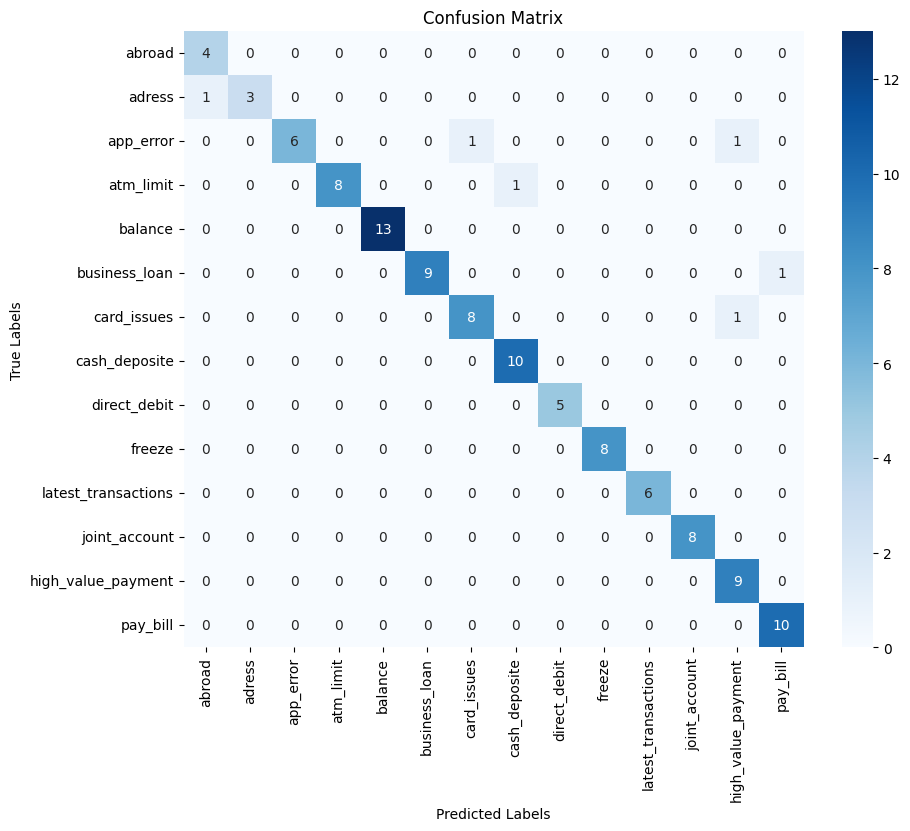

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Assuming intent_classes is a list of dictionaries,
# each dictionary having a 'name' key for the intent name
# Replace this with your actual intent_classes definition:
intent_classes = [
    {'index': 0, 'name': 'abroad'},
    {'index': 1, 'name': 'adress'},
    {'index': 2, 'name': 'app_error'},
    {'index': 3, 'name': 'atm_limit'},
    {'index': 4, 'name': 'balance'},
    {'index': 5, 'name': 'business_loan'},
    {'index': 6, 'name': 'card_issues'},
    {'index': 7, 'name': 'cash_deposite'},
    {'index': 8, 'name': 'direct_debit'},
    {'index': 9, 'name': 'freeze'},
    {'index': 10, 'name': 'latest_transactions'},
    {'index': 11, 'name': 'joint_account'},
    {'index': 12, 'name': 'high_value_payment'},
    {'index': 13, 'name': 'pay_bill'}
]

def detailed_evaluation(trainer, test_dataset):
    # Predict on the test set
    preds_output = trainer.predict(test_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels = preds_output.label_ids

    # Confusion matrix
    conf_matrix = confusion_matrix(labels, preds)  # This line calculates conf_matrix
    print("Confusion Matrix:\n", conf_matrix)

    # Classification report
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix visualization
    plt.figure(figsize=(10, 8))
    # Now conf_matrix is accessible here within the same function
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels= [i['name'] for i in intent_classes],
                yticklabels=[i['name'] for i in intent_classes])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Run detailed evaluation
detailed_evaluation(trainer, tokenized_test)

In [32]:
# prompt: save the model that already trained

trainer.save_model("./saved_model")

In [46]:
# prompt: show the result of trainer.evaluate using the test set

eval_result

{'eval_loss': 0.509617805480957,
 'eval_accuracy': 0.9469026548672567,
 'eval_precision': 0.9534995977473854,
 'eval_recall': 0.9469026548672567,
 'eval_f1': 0.9463111622540648,
 'eval_runtime': 3.4795,
 'eval_samples_per_second': 32.476,
 'eval_steps_per_second': 2.299,
 'epoch': 19.310344827586206}